In [2]:
import numpy as np
import pandas as pd
import mrcfile
import matplotlib.pyplot as plt

from torch_find_peaks import find_peaks_3d
from fle_3d import FLEBasis3D

In [3]:
# Choosing one large protein (per recommendation)
TEMPLATE_PATH = "5MRC_10.00A_solvent-4.530V_real.mrc"

with mrcfile.open(TEMPLATE_PATH, permissive=True) as m:
    template = m.data.astype(np.float32)

print("Template shape:", template.shape)

Template shape: (37, 37, 37)


/workspaces/fle3d-experiment1/.venv/lib/python3.10/site-packages/mrcfile/mrcinterpreter.py:206: RuntimeWarning: Map ID string not found - not an MRC file, or file is corrupt
  warnings.warn(msg, RuntimeWarning)


In [4]:
# building fle 3d and RI volume

fle = FLEBasis3D(
    N=template.shape[0],
    bandlimit=32,
    eps=1e-4
)

def rotation_invariant_volume(fle, volume):
    coeffs = fle.evaluate_t(volume)
    coeffs_tmp = np.zeros_like(coeffs)
    for k in fle.idlm_list[0][0]:   # l=0, m=0 only
        coeffs_tmp[k] = coeffs[k]
    return fle.evaluate(coeffs_tmp).real

template_ri = rotation_invariant_volume(fle, template)

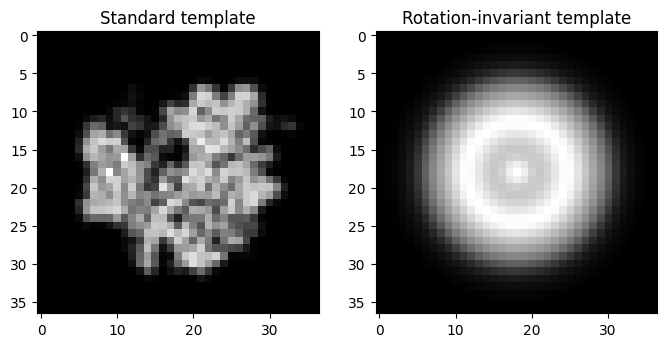

In [5]:
mid = template.shape[0] // 2

fig, axs = plt.subplots(1, 2, figsize=(8, 4))
axs[0].imshow(template[mid], cmap="gray")
axs[0].set_title("Standard template")

axs[1].imshow(template_ri[mid], cmap="gray")
axs[1].set_title("Rotation-invariant template")

plt.show()

In [6]:
with mrcfile.open("grandmodel.mrc", permissive=True) as m:
    grand_model = m.data.astype(np.float32)

with mrcfile.open("reconstruction.mrc", permissive=True) as m:
    reconstruction = m.data.astype(np.float32)

print("Grand model shape:", grand_model.shape)
print("Reconstruction shape:", reconstruction.shape)

/workspaces/fle3d-experiment1/.venv/lib/python3.10/site-packages/mrcfile/mrcinterpreter.py:206: RuntimeWarning: Map ID string not found - not an MRC file, or file is corrupt
  warnings.warn(msg, RuntimeWarning)
/workspaces/fle3d-experiment1/.venv/lib/python3.10/site-packages/mrcfile/mrcinterpreter.py:216: RuntimeWarning: Unrecognised machine stamp: 0x00 0x00 0x00 0x00
  warnings.warn(str(err), RuntimeWarning)


Grand model shape: (180, 512, 512)
Reconstruction shape: (512, 512, 512)


In [7]:
def compute_cc(volume, ref):
    # zero-pad template to volume size
    pad = np.zeros_like(volume)
    sz = ref.shape[0]
    pad[:sz, :sz, :sz] = ref

    F_vol = np.fft.fftn(volume)
    F_ref = np.fft.fftn(pad)

    cc = np.real(np.fft.ifftn(F_vol * np.conj(F_ref)))
    return cc

In [8]:
cc_std = compute_cc(grand_model, template)
cc_ri  = compute_cc(grand_model, template_ri)

cc_std = np.maximum(cc_std, 0)
cc_ri  = np.maximum(cc_ri, 0)

print("CC volumes computed")

CC volumes computed
